<h1>This is Inception-ResNet without convolutionnal layer after concatenate</h1>
<h2>With in build loss and accuracy</h2>

In [1]:
import os
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization,Activation, concatenate, DepthwiseConv2D, Multiply,Dropout
from keras.layers import GlobalAveragePooling2D, Dense, MaxPooling2D,Flatten, Layer,BatchNormalization, Add,Reshape,AveragePooling2D

from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt



In [2]:
tf.__version__

'2.9.0'

In [3]:
input_shape = (224, 224, 3)

train_dir = r'C:\Users\MSI-PC\Desktop\Level 6 curriculum\Corsework\Machine Vision\Coursework\DR Datasets\DRD_Split\train'
test_dir = r'C:\Users\MSI-PC\Desktop\Level 6 curriculum\Corsework\Machine Vision\Coursework\DR Datasets\DRD_Split\test'

batch_size = 8
num_classes = 2
# filter_factor = 8

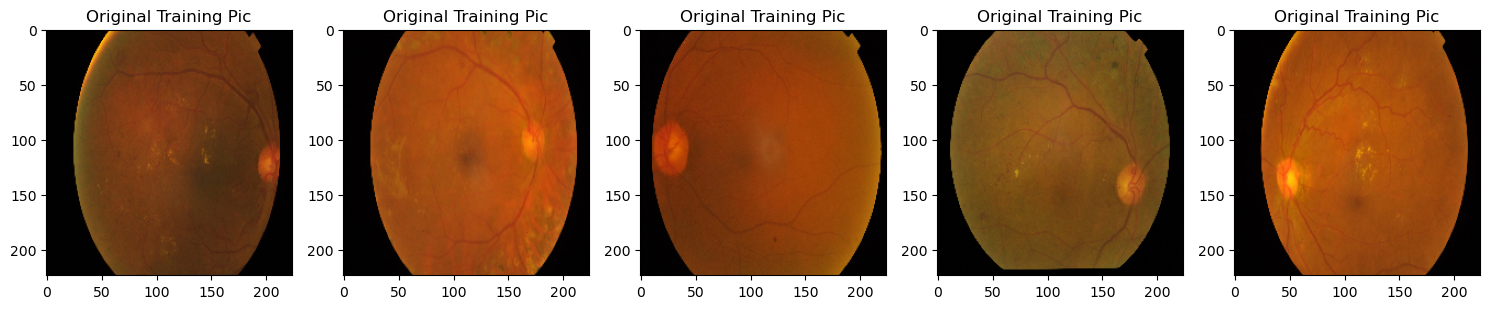

In [4]:
train_diabetic = r'C:\Users\MSI-PC\Desktop\Level 6 curriculum\Corsework\Machine Vision\Coursework\DR Datasets\DRD_Split\train\diabetic'

#Show the import original image
train_img_files = os.listdir(train_diabetic)
# test_img_files = os.listdir(test_dir)
# val_img_files = os.listdir(val_dir)

show_num = 5

plt.figure(figsize = (15, 5))

for i in range(show_num):
    
    img_path = os.path.join(train_diabetic, train_img_files[i])
    img = plt.imread(img_path)
    plt.subplot(1, show_num, i + 1)
    plt.imshow(img)
    plt.axis('on')
    plt.title("Original Training Pic")
    
plt.tight_layout()
plt.show()


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.13,  # Specify the validation split here
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load and preprocess the training and testing images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Use 'training' subset for training data
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Use 'validation' subset for validation data
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)




Found 2708 images belonging to 2 classes.
Found 404 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


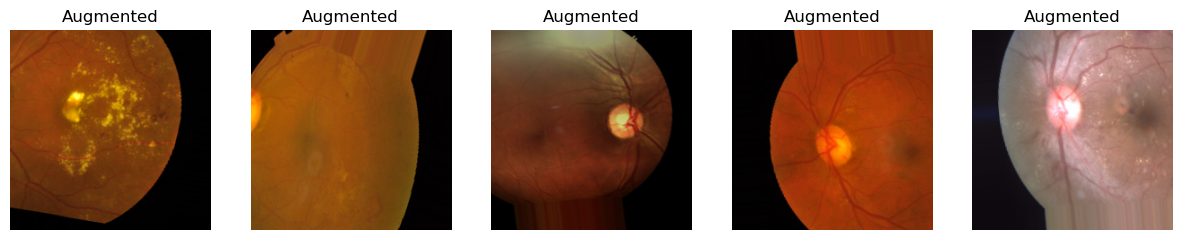

In [6]:
#To show the augmented pictures, after rotation, zoom in, rescale etc

# Extract a batch of images from the train_generator
sample_images, sample_labels = next(train_generator)

plt.figure(figsize = (15, 5))

# Show the original images from the batch
num_images_to_show = 5  # Show three images
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(sample_images[i-1])
    plt.title("Augmented")
    plt.axis('off')

In [7]:
def attention_block_2(x):
    # 使用卷积层创建一个更复杂的注意力机制
    attention_network = Conv2D(96, (3, 3), padding='same')(x)  # 增加卷积层
    attention_network = Activation('relu')(attention_network)
    attention_network = Conv2D(1, (1, 1), padding='same')(attention_network)  # 生成注意力图
    
    attention_output = Activation('sigmoid')(attention_network)
    scaled_feature = Multiply()([x, attention_output])  # 将注意力图应用于原始特征

    return scaled_feature

def simple_model_1(input_shape):
    inputs = Input(shape = input_shape)
    #Input convolution
    x = Conv2D(64, (3, 3), activation = 'leaky_relu',
               padding = 'same',kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = attention_block_2(x)
    x = MaxPooling2D(2, 2)(x)
    
    #First Dethwise Convolution
    x = Conv2D(64, (3, 3),  
               padding = 'same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = attention_block_2(x)
    x = MaxPooling2D(2, 2)(x)

    
    #Second convolutional layer
    x = Conv2D(32, (3, 3), 
               padding = 'same',kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = attention_block_2(x)
    x = MaxPooling2D(2, 2)(x)
    
    
    x = GlobalAveragePooling2D()(x)
    model_1 = Model(inputs, x)
    
    return model_1

def resnet_inception_simple(input_shape):
    inputs = Input(shape=input_shape)

    # Input Convolution
    x = Conv2D(32, (7, 7), strides=(1, 1), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual and Inception Blocks
    for filters in [32, 32, 64, 16]:
        # Residual Block
        x_r = Conv2D(filters, (3, 3), strides=(1, 1), padding='same', 
                     activation='relu',kernel_initializer='he_normal')(x)
        x_r = BatchNormalization()(x_r)
        x_r = Conv2D(filters, (3, 3), strides=(1, 1), padding='same', 
                     activation='relu',kernel_initializer='he_normal')(x_r)
        x_r = BatchNormalization()(x_r)

        # Inception Block
        branch_0 = Conv2D(64, (1, 1), padding='same', 
                          activation='relu',kernel_initializer='he_normal')(x)
        branch_0 = BatchNormalization()(branch_0)

        branch_1 = Conv2D(64, (1, 1), padding='same', 
                          activation='relu',kernel_initializer='he_normal')(x)
        branch_1 = BatchNormalization()(branch_1)
        branch_1 = Conv2D(32, (3, 3), padding='same', 
                          activation='relu',kernel_initializer='he_normal')(branch_1)
        branch_1 = BatchNormalization()(branch_1)

        branch_2 = Conv2D(128, (1, 1), padding='same', activation='relu',
                          kernel_initializer='he_normal')(x)
        branch_2 = BatchNormalization()(branch_2)
        branch_2 = Conv2D(32, (3, 3), padding='same', 
                          activation='relu',kernel_initializer='he_normal')(branch_2)
        branch_2 = BatchNormalization()(branch_2)
#         branch_2 = Conv2D(64, (3, 3), padding='same', activation='relu')(branch_2)
#         branch_2 = BatchNormalization()(branch_2)

#         branch_3 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
#         branch_3 = Conv2D(64, (1, 1), padding='same', activation='relu')(branch_3)
#         branch_3 = BatchNormalization()(branch_3)

        # Ensure concatenation along the channel axis
        x_i = concatenate([branch_0, branch_1,branch_2], axis = -1)
    
        # Make sure the number of filters after concatenation in x_i matches with x_r
        x_i = Conv2D(filters, (1, 1), padding = 'same', activation = 'relu')(x_i)
        x_i = BatchNormalization()(x_i)
        
        x_r = attention_block_2(x_r)
        x_i = attention_block_2(x_i)

        # Combine Residual and Inception Outputs
        x = Add()([x_r, x_i])
        x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
#     outputs = Dense(2, activation='softmax')(x)
    model = Model(inputs, x)
    
    return model



def build_ensemble_model(input_shape):
    inputs = Input(shape = input_shape)

    model_1 = simple_model_1(input_shape)
    output1 = model_1(inputs) 
    
    IR_output = resnet_inception_simple(input_shape)(inputs)
    
    combined_result = concatenate([output1, IR_output])
    
    combined_result = Dropout(0.5)(combined_result)
    
    # 最后的分类层
    outputs = Dense(2, activation='softmax')(combined_result)
    model = Model(inputs = inputs, outputs=outputs)
    
    return model

ensemble_model = build_ensemble_model(input_shape)



ensemble_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 32)           196643      ['input_1[0][0]']                
                                                                                                  
 model_1 (Functional)           (None, 16)           648056      ['input_1[0][0]']                
                                                                                                  
 concatenate_4 (Concatenate)    (None, 48)           0           ['model[0][0]',            

In [8]:
lr = 0.001
Optimizer = Adam(learning_rate = lr)

from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow_addons.metrics import F1Score

ensemble_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy', 
        Precision(), 
        Recall(), 
        AUC(), 
        F1Score(num_classes=2, average = micro)
    ]
)
lr_reduction = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1,
                                patience = 10,
                                min_lr = 0.00001,
                                verbose = 1)



In [9]:
history = ensemble_model.fit(train_generator, epochs = 100, validation_data=(validation_generator), callbacks = [lr_reduction])

Epoch 1/100
339/339 [==============================] - 73s 183ms/step - loss: 0.4239 - accuracy: 0.8235 - precision: 0.8235 - recall: 0.8235 - auc: 0.8920 - f1_score: 0.8229 - val_loss: 0.6841 - val_accuracy: 0.5124 - val_precision: 0.5124 - val_recall: 0.5124 - val_auc: 0.6518 - val_f1_score: 0.3477 - lr: 0.0010
Epoch 2/100
339/339 [==============================] - 59s 173ms/step - loss: 0.3238 - accuracy: 0.8796 - precision: 0.8796 - recall: 0.8796 - auc: 0.9376 - f1_score: 0.8795 - val_loss: 0.4871 - val_accuracy: 0.7376 - val_precision: 0.7376 - val_recall: 0.7376 - val_auc: 0.8413 - val_f1_score: 0.7345 - lr: 0.0010
Epoch 3/100
339/339 [==============================] - 59s 174ms/step - loss: 0.2970 - accuracy: 0.8892 - precision: 0.8892 - recall: 0.8892 - auc: 0.9481 - f1_score: 0.8891 - val_loss: 0.3595 - val_accuracy: 0.8267 - val_precision: 0.8267 - val_recall: 0.8267 - val_auc: 0.9254 - val_f1_score: 0.8256 - lr: 0.0010
Epoch 4/100
339/339 [==============================] - 

Epoch 27/100
339/339 [==============================] - 59s 173ms/step - loss: 0.1614 - accuracy: 0.9490 - precision: 0.9490 - recall: 0.9490 - auc: 0.9823 - f1_score: 0.9490 - val_loss: 0.1932 - val_accuracy: 0.9282 - val_precision: 0.9282 - val_recall: 0.9282 - val_auc: 0.9772 - val_f1_score: 0.9281 - lr: 0.0010
Epoch 28/100
339/339 [==============================] - 59s 173ms/step - loss: 0.1696 - accuracy: 0.9505 - precision: 0.9505 - recall: 0.9505 - auc: 0.9804 - f1_score: 0.9505 - val_loss: 0.1145 - val_accuracy: 0.9554 - val_precision: 0.9554 - val_recall: 0.9554 - val_auc: 0.9902 - val_f1_score: 0.9553 - lr: 0.0010
Epoch 29/100
339/339 [==============================] - 58s 170ms/step - loss: 0.1618 - accuracy: 0.9498 - precision: 0.9498 - recall: 0.9498 - auc: 0.9826 - f1_score: 0.9498 - val_loss: 0.1193 - val_accuracy: 0.9678 - val_precision: 0.9678 - val_recall: 0.9678 - val_auc: 0.9907 - val_f1_score: 0.9678 - lr: 0.0010
Epoch 30/100
339/339 [==============================

Epoch 53/100
339/339 [==============================] - 59s 173ms/step - loss: 0.1165 - accuracy: 0.9627 - precision: 0.9627 - recall: 0.9627 - auc: 0.9903 - f1_score: 0.9627 - val_loss: 0.0980 - val_accuracy: 0.9678 - val_precision: 0.9678 - val_recall: 0.9678 - val_auc: 0.9923 - val_f1_score: 0.9678 - lr: 1.0000e-04
Epoch 54/100
339/339 [==============================] - 58s 172ms/step - loss: 0.1199 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9900 - f1_score: 0.9601 - val_loss: 0.0849 - val_accuracy: 0.9728 - val_precision: 0.9728 - val_recall: 0.9728 - val_auc: 0.9944 - val_f1_score: 0.9728 - lr: 1.0000e-04
Epoch 55/100
339/339 [==============================] - 58s 171ms/step - loss: 0.1120 - accuracy: 0.9631 - precision: 0.9631 - recall: 0.9631 - auc: 0.9913 - f1_score: 0.9631 - val_loss: 0.0928 - val_accuracy: 0.9678 - val_precision: 0.9678 - val_recall: 0.9678 - val_auc: 0.9940 - val_f1_score: 0.9678 - lr: 1.0000e-04
Epoch 56/100
339/339 [==================

Epoch 78/100
339/339 [==============================] - 58s 171ms/step - loss: 0.0965 - accuracy: 0.9712 - precision: 0.9712 - recall: 0.9712 - auc: 0.9929 - f1_score: 0.9712 - val_loss: 0.0820 - val_accuracy: 0.9802 - val_precision: 0.9802 - val_recall: 0.9802 - val_auc: 0.9949 - val_f1_score: 0.9802 - lr: 1.0000e-05
Epoch 79/100
339/339 [==============================] - 58s 171ms/step - loss: 0.0998 - accuracy: 0.9716 - precision: 0.9716 - recall: 0.9716 - auc: 0.9916 - f1_score: 0.9716 - val_loss: 0.0801 - val_accuracy: 0.9777 - val_precision: 0.9777 - val_recall: 0.9777 - val_auc: 0.9950 - val_f1_score: 0.9777 - lr: 1.0000e-05
Epoch 80/100
339/339 [==============================] - 58s 171ms/step - loss: 0.0804 - accuracy: 0.9753 - precision: 0.9753 - recall: 0.9753 - auc: 0.9950 - f1_score: 0.9753 - val_loss: 0.1016 - val_accuracy: 0.9678 - val_precision: 0.9678 - val_recall: 0.9678 - val_auc: 0.9937 - val_f1_score: 0.9678 - lr: 1.0000e-05
Epoch 81/100
339/339 [==================

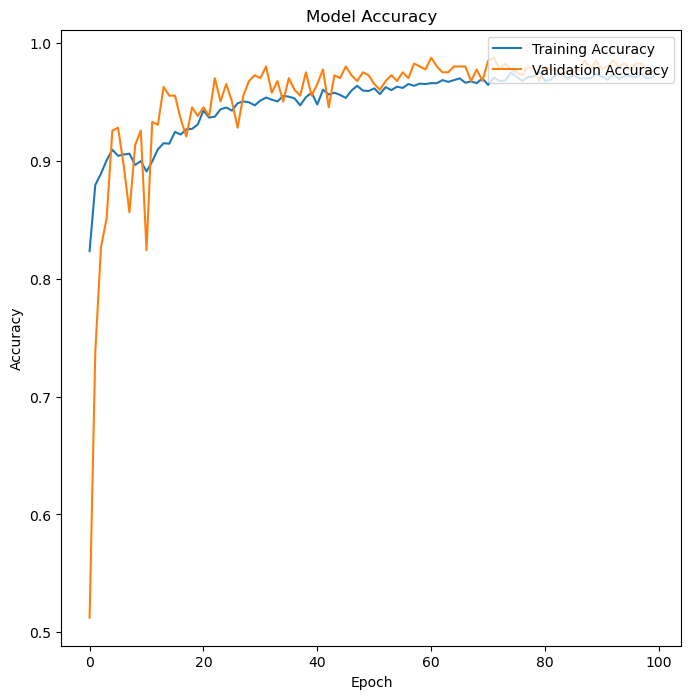

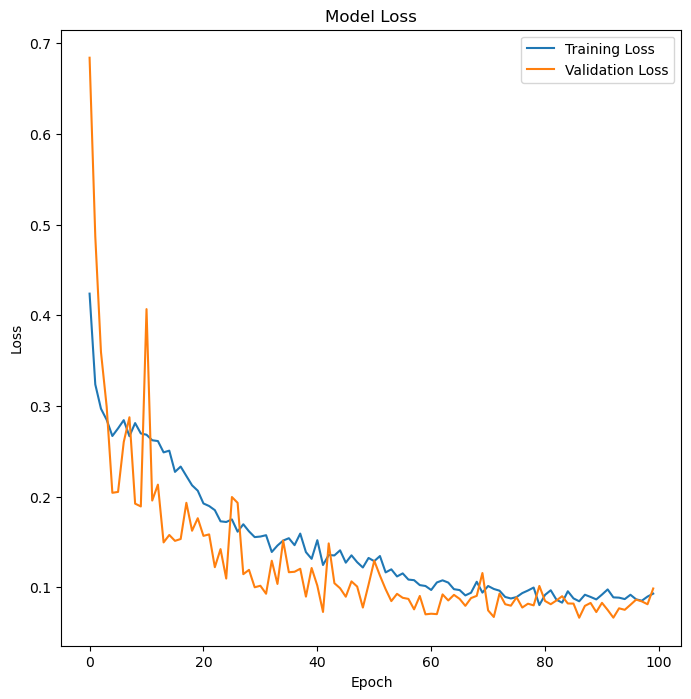

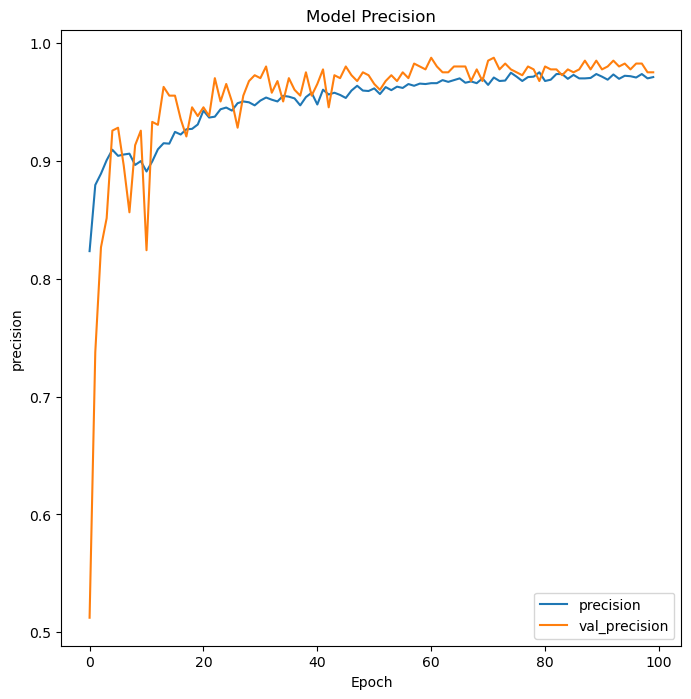

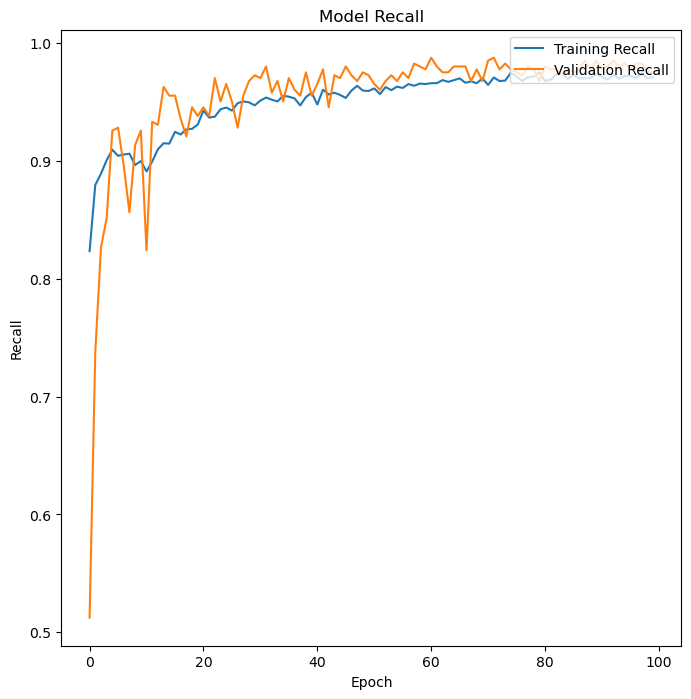

In [10]:
plt.figure(figsize = (8, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='upper right')
plt.show()


plt.figure(figsize=(8, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend(['precision', 'val_precision'], loc = 'lower right')
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Training Recall', 'Validation Recall'],loc='lower right')
plt.show()

17/17 [==============================] - 9s 310ms/step


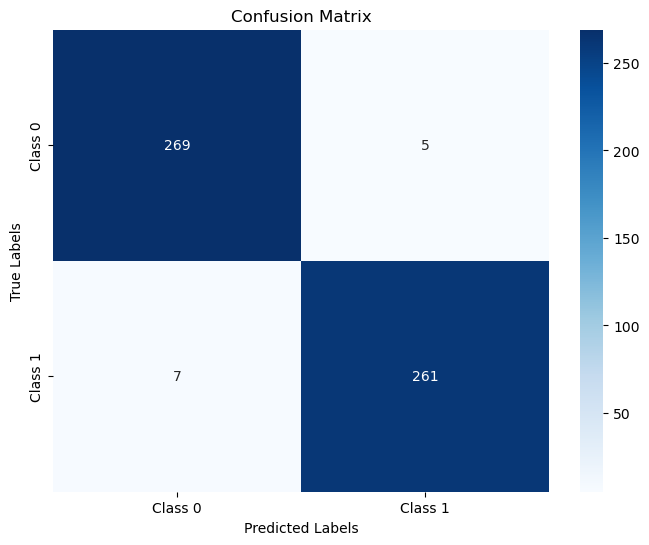

In [12]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 收集图像和真实标签
all_images, all_true_labels = zip(*[next(test_generator) for _ in range(test_generator.samples // test_generator.batch_size)])
all_images = np.concatenate(all_images)
all_true_labels = np.argmax(np.concatenate(all_true_labels), axis=1)

# 进行预测并获取预测标签
predictions = ensemble_model.predict(all_images)
predicted_labels = np.argmax(predictions, axis=1)

# 生成并绘制混淆矩阵
conf_matrix = confusion_matrix(all_true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [13]:
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1_score = ensemble_model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test precision:', test_precision)
print('Test recall:', test_recall)
print('Test AUC:', test_auc)
print('Test F1 Score:', test_f1_score)

69/69 [==============================] - 5s 68ms/step - loss: 0.0752 - accuracy: 0.9782 - precision: 0.9782 - recall: 0.9782 - auc: 0.9944 - f1_score: 0.9782
Test loss: 0.07520008832216263
Test accuracy: 0.9781818389892578
Test precision: 0.9781818389892578
Test recall: 0.9781818389892578
Test AUC: 0.9944115281105042
Test F1 Score: [0.9785714 0.9777778]


In [14]:
#compute sensitivity and specificity
sensitivity=tpr[1] #True positive rate 
specificity= 1-fpr[1]

print('sensitivity:', sensitivity)
print('specificity:', specificity)

NameError: name 'tpr' is not defined

In [15]:
#delete the model to prevent memory costs

from keras import backend as K
import gc

K.clear_session()
gc.collect()

del ensemble_model


from numba import cuda

cuda.select_device(0)
cuda.close()